In [1]:
from pathlib import Path

import torch
import torch.nn as nn
from torch.optim import Adam
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms, models


In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device


device(type='cpu')

In [3]:
DATA_DIR = Path("../data/raw")  # adjust to "data/raw" if notebook is in project root

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],  # standard ImageNet values
        std=[0.229, 0.224, 0.225],
    ),
])

full_dataset = datasets.ImageFolder(root=str(DATA_DIR), transform=transform)
class_names = full_dataset.classes
len(full_dataset), class_names


(20, ['damaged', 'undamaged'])

In [4]:
val_split = 0.2
val_len = max(1, int(len(full_dataset) * val_split))
train_len = len(full_dataset) - val_len

train_ds, val_ds = random_split(full_dataset, [train_len, val_len])

batch_size = 8

train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_ds, batch_size=batch_size, shuffle=False)

len(train_ds), len(val_ds)

(16, 4)

In [5]:
num_classes = len(class_names)

model = models.resnet18(weights=models.ResNet18_Weights.DEFAULT)
in_features = model.fc.in_features
model.fc = nn.Linear(in_features, num_classes)

model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = Adam(model.parameters(), lr=1e-4)


Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to C:\Users\raora/.cache\torch\hub\checkpoints\resnet18-f37072fd.pth


100.0%


In [6]:
num_epochs = 5

for epoch in range(1, num_epochs + 1):
    model.train()
    running_loss = 0.0
    running_correct = 0
    running_total = 0

    for images, labels in train_loader:
        images = images.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        _, preds = torch.max(outputs, 1)
        running_loss += loss.item() * images.size(0)
        running_correct += torch.sum(preds == labels).item()
        running_total += labels.size(0)

    train_loss = running_loss / running_total
    train_acc = running_correct / running_total

    # validation
    model.eval()
    val_correct = 0
    val_total = 0
    with torch.no_grad():
        for images, labels in val_loader:
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)
            val_correct += torch.sum(preds == labels).item()
            val_total += labels.size(0)

    val_acc = val_correct / val_total if val_total > 0 else 0.0

    print(
        f"Epoch {epoch}/{num_epochs} "
        f"| train_loss={train_loss:.4f} "
        f"| train_acc={train_acc:.3f} "
        f"| val_acc={val_acc:.3f}"
    )


Epoch 1/5 | train_loss=0.6569 | train_acc=0.562 | val_acc=0.750
Epoch 2/5 | train_loss=0.1905 | train_acc=0.938 | val_acc=0.750
Epoch 3/5 | train_loss=0.1328 | train_acc=0.938 | val_acc=0.750
Epoch 4/5 | train_loss=0.0165 | train_acc=1.000 | val_acc=0.750
Epoch 5/5 | train_loss=0.0326 | train_acc=1.000 | val_acc=0.750


In [7]:
from pathlib import Path
OUTPUTS_DIR = Path("../outputs")
OUTPUTS_DIR.mkdir(exist_ok=True)

save_path = OUTPUTS_DIR / "building_damage_resnet18.pth"

torch.save(
    {
        "model_state_dict": model.state_dict(),
        "class_names": class_names,
    },
    save_path,
)
save_path

WindowsPath('../outputs/building_damage_resnet18.pth')

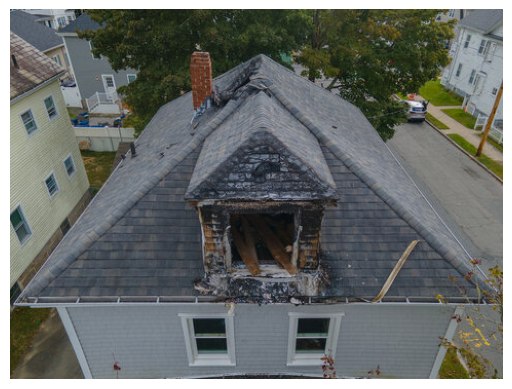

damaged: 0.995
undamaged: 0.005
Prediction: damaged


In [8]:
from PIL import Image
import matplotlib.pyplot as plt
import torch.nn.functional as F

def predict_image(path):
    img = Image.open(path).convert("RGB")
    plt.imshow(img)
    plt.axis("off")
    plt.show()

    x = transform(img).unsqueeze(0).to(device)
    model.eval()
    with torch.no_grad():
        logits = model(x)
        probs = F.softmax(logits, dim=1)[0].cpu().numpy()

    for cls, p in zip(class_names, probs):
        print(f"{cls}: {p:.3f}")
    print("Prediction:", class_names[probs.argmax()])

# example:
test_img_path = list((DATA_DIR / "damaged").glob("*"))[0]
predict_image(test_img_path)


In [9]:
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np

# collect all predictions on full dataset
all_loader = DataLoader(full_dataset, batch_size=8, shuffle=False)

model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels in all_loader:
        images = images.to(device)
        labels = labels.to(device)

        outputs = model(images)
        _, preds = torch.max(outputs, 1)

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

all_preds = np.array(all_preds)
all_labels = np.array(all_labels)

print("Classification report:\n")
print(classification_report(all_labels, all_preds, target_names=class_names))


Classification report:

              precision    recall  f1-score   support

     damaged       0.91      1.00      0.95        10
   undamaged       1.00      0.90      0.95        10

    accuracy                           0.95        20
   macro avg       0.95      0.95      0.95        20
weighted avg       0.95      0.95      0.95        20



In [11]:
pip install seaborn

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: C:\Users\raora\AppData\Local\Programs\Python\Python314\python.exe -m pip install --upgrade pip


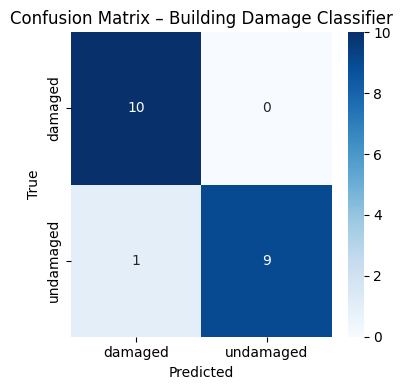

In [12]:
import matplotlib.pyplot as plt
import seaborn as sns

cm = confusion_matrix(all_labels, all_preds)

plt.figure(figsize=(4, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix – Building Damage Classifier")
plt.tight_layout()
plt.show()


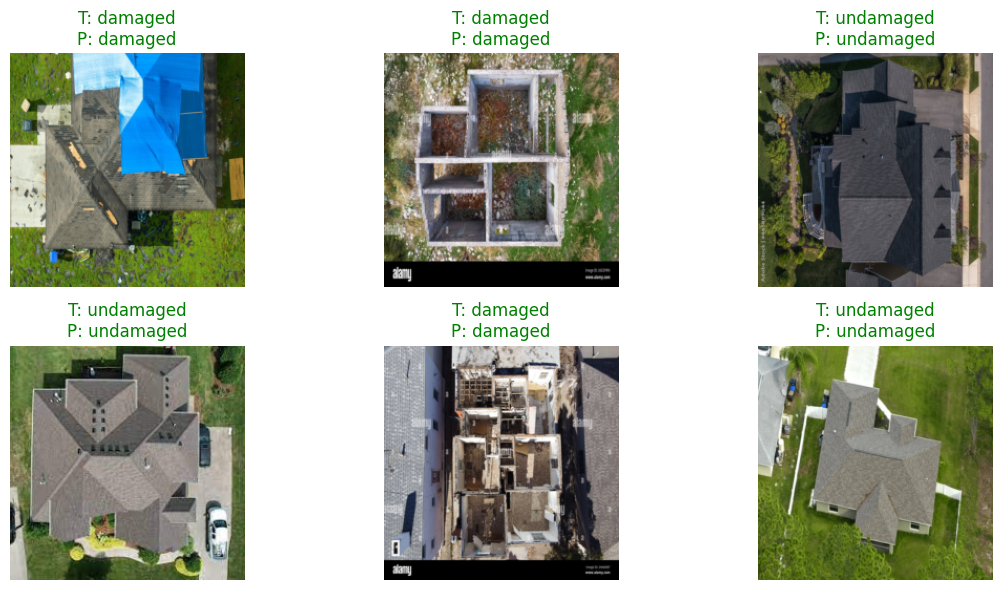

In [13]:
import random

def show_random_predictions(n=6):
    idxs = random.sample(range(len(full_dataset)), n)
    plt.figure(figsize=(12, 6))

    for i, idx in enumerate(idxs, 1):
        img, label = full_dataset[idx]
        true_label = class_names[label]

        model.eval()
        with torch.no_grad():
            x = img.unsqueeze(0).to(device)
            out = model(x)
            pred = out.argmax(dim=1).item()
        pred_label = class_names[pred]

        plt.subplot(2, (n + 1) // 2, i)
        # unnormalize for display
        display_img = img.permute(1, 2, 0).numpy()
        display_img = display_img * [0.229, 0.224, 0.225] + [0.485, 0.456, 0.406]
        display_img = display_img.clip(0, 1)

        plt.imshow(display_img)
        color = "green" if true_label == pred_label else "red"
        plt.title(f"T: {true_label}\nP: {pred_label}", color=color)
        plt.axis("off")

    plt.tight_layout()
    plt.show()

show_random_predictions()
